In [1]:
# Loading in libraries necessary for CNN
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, Adagrad, RMSprop, SparseAdam, LBFGS, Adadelta
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot
import time
import torch.nn.functional as F
import nmrsim
from nmrsim import plt
from itertools import product

# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
#print(torch.cuda.get_device_name(0))

Using cuda device


In [2]:
#Checking how many files are in repository for training, testing, and validation
files = glob.glob('./Spectral_Data/spectral_data/400MHz/*.csv')
print('Total number of files: ', len(files))


Total number of files:  9080


Establishing a Dataloader for 400MHz dataset

In [3]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading starting with list of csv strings
        self.files = glob.glob(os.path.join('./Spectral_Data/spectral_data/400MHz', 
                                                       'spectral_data_*.csv'))

        self.y_60 = [] # Establishes a list for 60 MHz data
        self.y_400 = [] # Establishes a list for 400 MHz data

        for self.file in self.files: # For loop for each file in files
            self.df = pd.read_csv(self.file) # Reads each into a pandas dataframe
            self.array_60 = self.df['60MHz_intensity'].to_numpy() # Takes 60MHz intensity to np
            self.array_400 = self.df['400MHz_intensity'].to_numpy() # Takes 400MHz intensity to np
            self.y_60.append(self.array_60) # Appends all arrays to 60MHz list
            self.y_400.append(self.array_400) # Appends all arrays to 400MHz list
            
        # Creates a 60 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_60 = torch.Tensor(self.y_60).float().unsqueeze(1).to(device)        

        # Creates a 400 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_400 = torch.Tensor(self.y_400).float().unsqueeze(1).to(device)
        
        # Track the length of number of samples in frame
        self.num_samples = len(self.y_60)

    def __getitem__(self, index): # establishes an index for the tensors
        return self.tensor_60[index], self.tensor_400[index]
    
    def __len__(self): # Returns variable number of samples
        return self.num_samples
    
  

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(5500,1024) # input layer to hidden
        self.relu = nn.ReLU() # activation function
        self.fc2 = nn.Linear(1024,128) # input layer to output
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128,512)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 4000)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(4000, 5500)
            
    def forward(self, x):  # Forward loop for the neural network
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

In [5]:
model = NeuralNetwork().to(device) # Assigns model to variable model, sends to gpu

In [6]:
# Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_400,
                                                    test_size=0.1)

# Splits train data into validation data
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                      test_size=0.1)
# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)
valid_dataset = TensorDataset(valid_X, valid_y)

# Batch size change to higher batch sizes
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

/home/garrettreinhard/miniconda3/envs/isotope/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


In [7]:
criterion = nn.MSELoss() # Loss function for the model

In [8]:
#RMSprop and Adam seems to work ptetty well
optimizer = RMSprop(model.parameters(), lr=0.01) # Optimization function

In [9]:
num_epochs = 30 # Number of epochs to run model

In [10]:
time_ = time.time() # Assigns time to variable time_

train_loss_epoch = []

for e in range(num_epochs):
    running_loss = 0.0
    
    for index, (inputs, labels) in enumerate(train_dataloader):
        #inputs = inputs.squeeze(1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(1)
        
        
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_loss_epoch.append(epoch_loss)
    
    if(int(e) % 10) == 0:
        print(f'Epoch {e} loss: {epoch_loss:.4f}')

print(f'Time Elapsed: {round(time.time()-time_, 5)} seconds')


Epoch 0 loss: 6912.2888
Epoch 10 loss: 0.0001
Epoch 20 loss: 0.0001
Time Elapsed: 267.58232 seconds


In [11]:
valid_loss_epoch = []

for e in range(num_epochs):
    running_loss = 0.0
    loss_list_valid = []
     
    model.eval() # Model to evaluation mode

    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0
    loss_list_test = []

    # Loop for testing
    for inputs, labels in valid_dataloader:
        #Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(1)

        _, labels = torch.min(labels, 1)
        _, predicts = torch.min(outputs.data, 1)
        predicts = predicts.unsqueeze(1)
        valid_total += labels.size(0)
        valid_correct += (predicts == labels).float().mean()
        
    epoch_loss = valid_loss / len(valid_dataloader.dataset)
    valid_loss_epoch.append(epoch_loss)  


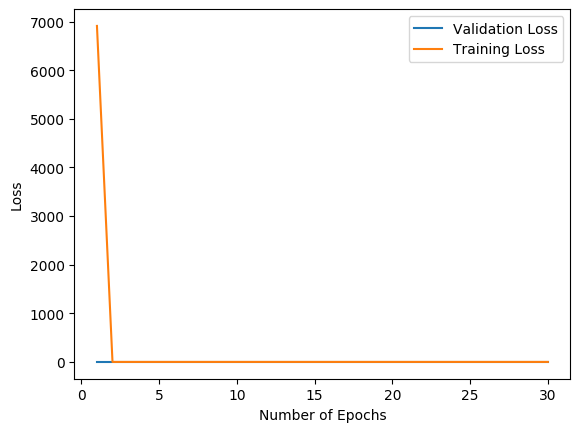

In [12]:
x = np.linspace(1, num_epochs, num_epochs)

fig, ax = matplotlib.pyplot.subplots()
ax.plot(x, valid_loss_epoch, label='Validation Loss')
ax.plot(x, train_loss_epoch, label='Training Loss' )
#matplotlib.pyplot.xlim([5, 25])
matplotlib.pyplot.xlabel('Number of Epochs')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [13]:
# Evaluating Model Performance with Test Data

model.eval() # Model to evaluation mode

test_loss = 0.0
test_correct = 0
test_total = 0
loss_list_test = []

# Loop for testing
for inputs, labels in test_dataloader:
    #Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item() * inputs.size(1)
    loss_list_test.append(loss)
    
    _, labels = torch.min(labels, 1)
    _, predicts = torch.min(outputs.data, 1)
    predicts = predicts.unsqueeze(1)
    test_total += labels.size(0)
    test_correct += (predicts == labels).float().mean()

accuracy = (test_correct / test_total)*100
test_loss /= len(test_dataloader.dataset)
print(f' Mean Loss of Function: {test_loss}, Accuracy: {accuracy}')
print(labels.shape, outputs.shape)

 Mean Loss of Function: 8.78704381267651e-06, Accuracy: 0.8810572624206543
torch.Size([12, 5500]) torch.Size([12, 1, 5500])


In [14]:
model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        inputs = inputs.squeeze(1)
        predictions = model(inputs)

predictions_numpy = predictions.cpu().numpy()
pred = pd.DataFrame(predictions_numpy)

In [15]:
df_60 = pd.read_csv('./Spectral_Data/spectral_data/400MHz/Test_Data/spectral_data_16_00238.csv')
df_x = df_60['60MHz_intensity']
df_x = df_x.to_numpy()
df_x = torch.Tensor(df_x).to(device)

In [16]:
predictions = model(df_x)
predictions_numpy = predictions.detach().cpu().numpy()
predictions_numpy

array([ 0.0049939 ,  0.00499396,  0.00499402, ..., -0.00496256,
       -0.00496259,  0.0049824 ], dtype=float32)

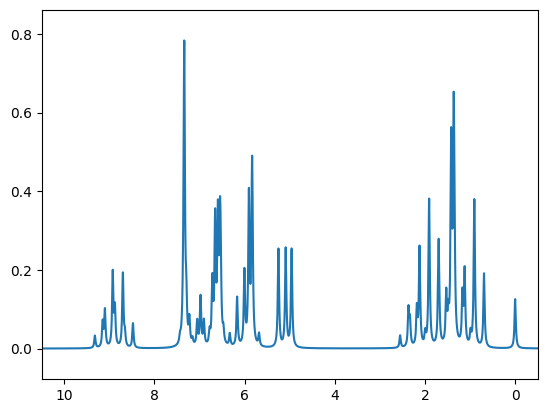

(0       -0.500000
 1       -0.498000
 2       -0.495999
 3       -0.493999
 4       -0.491999
           ...    
 5495    10.491999
 5496    10.493999
 5497    10.495999
 5498    10.498000
 5499    10.500000
 Name: 60MHz_ppm, Length: 5500, dtype: float64,
 0       0.000456
 1       0.000458
 2       0.000460
 3       0.000461
 4       0.000463
           ...   
 5495    0.000176
 5496    0.000176
 5497    0.000176
 5498    0.000175
 5499    0.000175
 Name: 60MHz_intensity, Length: 5500, dtype: float64)

In [17]:
nmrsim.plt.mplplot_lineshape(df_60['60MHz_ppm'], df_60['60MHz_intensity'], limits=(-0.5, 10.5))

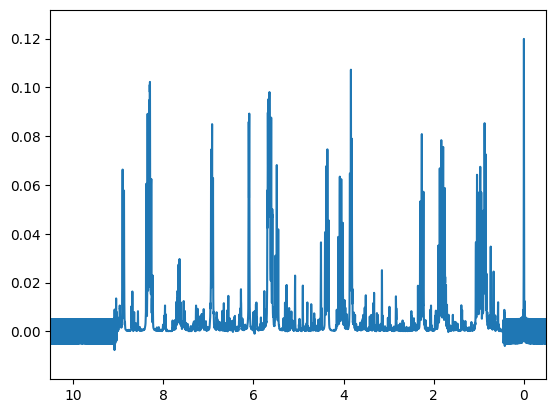

(array([-0.5       , -0.49799964, -0.49599927, ..., 10.49599927,
        10.49799964, 10.5       ]),
 array([ 0.0049939 ,  0.00499396,  0.00499402, ..., -0.00496256,
        -0.00496259,  0.0049824 ], dtype=float32))

In [18]:
x = np.linspace(-.5,10.5,5500)
y = predictions_numpy


nmrsim.plt.mplplot_lineshape(x, y, limits=(-0.5, 10.5))

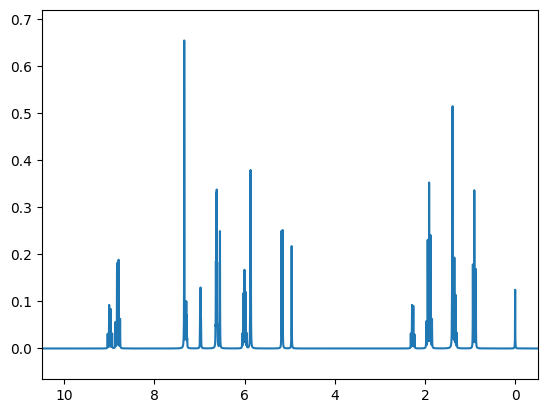

(array([-0.5       , -0.49799964, -0.49599927, ..., 10.49599927,
        10.49799964, 10.5       ]),
 array([1.01221499e-05, 1.01622657e-05, 1.02027392e-05, ...,
        3.87002634e-06, 3.86355431e-06, 3.85710203e-06]))

In [19]:
nmrsim.plt.mplplot_lineshape(np.array(df_60['400MHz_ppm']), np.array(df_60['400MHz_intensity']), limits=(-0.5, 10.5))

In [20]:
test = glob.glob(os.path.join('./Spectral_Data/spectral_data/400MHz', 
                                                       'spectral_data_*.csv'))

y_60 = []
y_400 = []

for file in test:
    df = pd.read_csv(file)
    array_60 = df['60MHz_intensity'].to_numpy()
    array_400 = df['400MHz_intensity'].to_numpy()
    y_60.append(array_60)
    y_400.append(array_400)

tensor = torch.Tensor(y_400)
reshaped_tensor = tensor.unsqueeze(1)
reshaped_tensor_2 = reshaped_tensor.squeeze(1)

print(reshaped_tensor.shape)
print(reshaped_tensor_2.shape)

torch.Size([9080, 1, 5500])
torch.Size([9080, 5500])
